# Euchre Trick Model
Model to estimate the number of tricks a given hand will be able to take  
(or maybe the percent likelihood of each number of tricks taken 0-5)

In [1]:
import pandas as pd

In [40]:
raw_train_df = pd.read_csv('all_hand_results.csv')

In [41]:
raw_train_df.shape

(471380, 14)

In [42]:
raw_train_df.head()

,tricks_won,is_calling_player,teammate_called,has_right,has_left,has_Atrump,has_Ktrump,has_Qtrump,has_Ttrump,has_9trump,num_off_A,num_off_K,num_off_Q,partner_tricks
0,0,0,1,0,0,0,0,0,0,1,0,1,0,3
1,1,0,0,0,0,0,0,0,0,0,1,2,2,1
2,3,1,0,1,0,0,1,0,1,0,0,0,0,0
3,1,0,0,0,1,0,0,1,0,0,0,0,1,1
4,0,0,0,0,0,0,0,0,1,0,0,0,1,0


In [43]:
raw_train_df.columns

Index(['tricks_won', 'is_calling_player', 'teammate_called', 'has_right',
       'has_left', 'has_Atrump', 'has_Ktrump', 'has_Qtrump', 'has_Ttrump',
       'has_9trump', 'num_off_A', 'num_off_K', 'num_off_Q', 'partner_tricks'],
      dtype='object')

<AxesSubplot:>

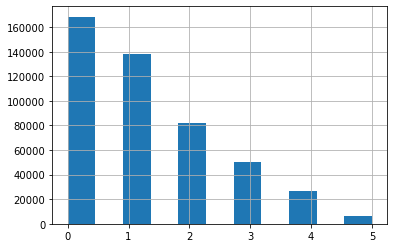

In [44]:
raw_train_df['tricks_won'].hist(bins=11)

In [69]:
raw_train_df['team_tricks_won'] = raw_train_df['partner_tricks'] + raw_train_df['tricks_won']

### Create train/test/validation splits

In [45]:
model_features = ['has_right', 'has_left',
                  'has_Atrump', 'has_Ktrump', 'has_Qtrump', 'has_Ttrump', 'has_9trump', 
                  'num_off_A', 'num_off_K', 'num_off_Q'
                 ]

In [46]:
from sklearn.model_selection import train_test_split

In [47]:
train_df, test_df, train_targets_df, test_targets_df = train_test_split(raw_train_df[model_features], 
                                                    raw_train_df['tricks_won'], 
                                                    test_size=0.33, random_state=42)

In [48]:
train_df.shape

(315824, 10)

In [49]:
test_df.shape

(155556, 10)

#### Scale Features

In [50]:
from sklearn.preprocessing import StandardScaler

In [51]:
sc = StandardScaler()
train_df = sc.fit_transform(train_df)
test_df = sc.transform (test_df)

## Modeling

#### Linear Regression

In [52]:
from sklearn.linear_model import LinearRegression

In [53]:
reg = LinearRegression().fit(train_df, train_targets_df)

In [54]:
reg.coef_

array([0.69818479, 0.38057349, 0.22997111, 0.36298278, 0.33991518,
       0.31749635, 0.29141776, 0.16131696, 0.22302263, 0.06281799])

In [55]:
test_preds = reg.predict(test_df)

In [56]:
test_preds[0:5]

array([-0.32515471,  0.44863807,  0.60795654,  2.60017615,  1.72360765])

#### Test single hand manually

In [57]:
hand = {feature:[0] for feature in model_features}
single_hand_test_df = pd.DataFrame(hand)
single_hand_test_df

,has_right,has_left,has_Atrump,has_Ktrump,has_Qtrump,has_Ttrump,has_9trump,num_off_A,num_off_K,num_off_Q
0,0,0,0,0,0,0,0,0,0,0


In [58]:
single_hand_test_df['has_right'] = 0
single_hand_test_df['has_left'] = 0
single_hand_test_df['has_Atrump'] = 0
single_hand_test_df['has_Ktrump'] = 1
single_hand_test_df['has_Qtrump'] = 1
single_hand_test_df['has_Ttrump'] = 1
single_hand_test_df['has_9trump'] = 0
single_hand_test_df['num_off_Q'] = 2
single_hand_test_df['num_off_K'] = 0
single_hand_test_df['num_off_A'] = 0

In [59]:
single_test_pred = reg.predict(single_hand_test_df)
single_test_pred

array([2.39703401])

#### Random Forest

In [60]:
from sklearn.ensemble import RandomForestClassifier

In [61]:
classifier =  RandomForestClassifier(criterion = 'entropy')

In [62]:
# Fit the best algorithm to the data
classifier.fit(train_df, train_targets_df)

RandomForestClassifier(criterion='entropy')

In [63]:
test_preds = classifier.predict(test_df)
# test_preds = classifier.predict_proba(test_df)
test_preds[0:3]

array([0, 0, 0], dtype=int64)

In [64]:
single_hand_preds = classifier.predict_proba(single_hand_test_df)
single_hand_preds

array([[0.02688965, 0.23166298, 0.4359136 , 0.24669614, 0.05009656,
        0.00874107]])

In [65]:
trick_preds = single_hand_preds.tolist()[0]
trick_preds

[0.026889652800185473,
 0.23166298348929204,
 0.4359136004040256,
 0.24669613583853006,
 0.05009656051925045,
 0.00874106694871627]

#### Save out model to disk using joblib

In [ ]:
import joblib

In [ ]:
pwd

In [ ]:
# TODO: update this to write to C:/Users/jerem/Desktop/nonsense/euchre/models/
# joblib.dump(classifier, 'trick_model_rf_v0.sav')

#### Plot probability output

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
num_tricks_taken = ['0','1','2','3','4','5']
ax.bar(num_tricks_taken, single_hand_preds.tolist()[0])

plt.xlabel("Tricks taken")
plt.ylabel("Percent of hands")
plt.title("Expected tricks taken")

# ax.bar_label(trick_preds, label_type='center')

plt.show()

In [ ]:
def plot_expected_tricks_taken(expected_tricks_taken):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(['0','1','2','3','4','5'], expected_tricks_taken)
    plt.xlabel("Tricks taken")
    plt.ylabel("Percent of hands")
    plt.title("Expected tricks taken")
    plt.show()

In [ ]:
plot_expected_tricks_taken(expected_tricks_taken = trick_preds)

### Evalute model

In [28]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [66]:
mean_absolute_error(y_true=test_targets_df, y_pred=test_preds)

0.4488415747383579

In [67]:
mean_squared_error(y_true=test_targets_df, y_pred=test_preds)

0.5824269073516933

In [68]:
r2_score(y_true=test_targets_df, y_pred=test_preds)

0.6381494396820335

#### Pipeline

In [ ]:
from sklearn.pipeline import Pipeline

In [ ]:
pipe = Pipeline([
        ('scale', StandardScaler()),
        ('reduce_dims', PCA(n_components=4)),
        ('clf', SVC(kernel = 'linear', C = 1))])

## Next Steps

In [ ]:
# Features - add player position at table, team tricks won

# Standardize input features to linear model
# Cross-validate tree-based models - RF, GBM, etc.
# Look at feature importance
# sklearn pipeline

# PyTorch models
    # compare PyTorch version vs. sklearn
# Classification models to predict likelihood for each score outcome

# Is it possible to take a trick with an off-suit Jack, that wouldn't have been taken with the 10 or 9 ???

# Is there ever a time when knowing the current score of the game should affect which card to play?
    # If opponent has 9 points, play more aggressively?

# Is there ever a time when knowing the current number of tricks taken should affect which card to play?
    # If opponents have taken 2 tricks already, play more aggressively?


In [ ]:
def translate_st_input_to_df(trump, 
                             a_s=False, k_s=False, q_s=False, j_s=False, t_s=False, nine_s=False, 
                             j_c=False):
    """
    Function to take in checkbox inputs and return
    
    :return dataframe
    """
    model_features = ['has_right', 'has_left',
                      'has_Atrump', 'has_Ktrump', 'has_Qtrump', 'has_Ttrump', 'has_9trump',
                      'num_off_A', 'num_off_K', 'num_off_Q'
                      ]
    hand = {feature: [0] for feature in model_features}
    df = pd.DataFrame(hand)
    if trump == 'SPADES':
        if a_s:
            df['has_Atrump'] = 1
        if k_s:
            df['has_Ktrump'] = 1
        if q_s:
            df['has_Qtrump'] = 1
        if j_s:
            df['has_right'] = 1
        if t_s:
            df['has_Ttrump'] = 1
        if nine_s:
            df['has_9trump'] = 1
        if j_c:
            df['has_left'] = 1

    if trump == 'CLUBS':
        if a_c:
            df['has_Atrump'] = 1
        if k_c:
            df['has_Ktrump'] = 1
        if q_c:
            df['has_Qtrump'] = 1
        if j_c:
            df['has_right'] = 1
        if t_c:
            df['has_Ttrump'] = 1
        if nine_c:
            df['has_9trump'] = 1
        if j_s:
            df['has_left'] = 1

    if trump == 'DIAMONDS':
        if a_d:
            df['has_Atrump'] = 1
        if k_d:
            df['has_Ktrump'] = 1
        if q_d:
            df['has_Qtrump'] = 1
        if j_d:
            df['has_right'] = 1
        if t_d:
            df['has_Ttrump'] = 1
        if nine_d:
            df['has_9trump'] = 1
        if j_h:
            df['has_left'] = 1

    if trump == 'HEARTS':
        if a_h:
            df['has_Atrump'] = 1
        if k_h:
            df['has_Ktrump'] = 1
        if q_h:
            df['has_Qtrump'] = 1
        if j_h:
            df['has_right'] = 1
        if t_h:
            df['has_Ttrump'] = 1
        if nine_h:
            df['has_9trump'] = 1
        if j_d:
            df['has_left'] = 1

    return df

In [ ]:
translate_st_input_to_df(trump='S', 
                         a_s=False,
                         k_s=False,
                         q_s=False,
                         j_s=False, 
                         t_s=False,
                         nine_s=False,
                         j_c=False)